# Bigram Language Modeling using a basic Neural Network for generating Onion-like News Headlines

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

## Data Setup

In [2]:
try:
  onion_df = pd.read_csv('../data/cleaned_onion_headlines.csv')
except FileNotFoundError:
  onion_df = pd.read_csv('../data/original_onion_headlines.csv')
  onion_df['text'] = onion_df['text'].str.encode('ascii', 'ignore').str.decode('ascii')
  onion_df['text'] = onion_df['text'].apply(str.lower)
  onion_df['text'] = onion_df['text'].apply(lambda t: re.sub('[$=`+@*#_]', '', t))
  onion_df.to_csv('../data/cleaned_onion_headlines.csv', index=None)

onion_df.shape

(14363, 1)

In [3]:
onion_df['length'] = onion_df['text'].apply(len)
onion_df['length'].describe()

count    14363.000000
mean        77.819745
std         30.673678
min          1.000000
25%         56.500000
50%         75.000000
75%         94.000000
max        283.000000
Name: length, dtype: float64

## Bigram Language Model

In [4]:
texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
len(vocab)

55

In [5]:
xs,ys = [],[]
for text in texts[:1]:
  chs = ['#'] + list(text) + ['#']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = stoi[ch1]
    idx2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(idx1)
    ys.append(idx2)

xs,ys = torch.tensor(xs),torch.tensor(ys)

# e
e n
n t
t i
i r
r e
e  
  f
f a
a c
c e
e b
b o
o o
o k
k  
  s
s t
t a
a f
f f
f  
  l
l a
a u
u g
g h
h s
s  
  a
a s
s  
  m
m a
a n
n  
  t
t i
i g
g h
h t
t e
e n
n s
s  
  p
p r
r i
i v
v a
a c
c y
y  
  s
s e
e t
t t
t i
i n
n g
g s
s #


In [6]:
xs

tensor([ 0, 32, 41, 47, 36, 45, 32,  1, 33, 28, 30, 32, 29, 42, 42, 38,  1, 46,
        47, 28, 33, 33,  1, 39, 28, 48, 34, 35, 46,  1, 28, 46,  1, 40, 28, 41,
         1, 47, 36, 34, 35, 47, 32, 41, 46,  1, 43, 45, 36, 49, 28, 30, 52,  1,
        46, 32, 47, 47, 36, 41, 34, 46])

In [7]:
ys

tensor([32, 41, 47, 36, 45, 32,  1, 33, 28, 30, 32, 29, 42, 42, 38,  1, 46, 47,
        28, 33, 33,  1, 39, 28, 48, 34, 35, 46,  1, 28, 46,  1, 40, 28, 41,  1,
        47, 36, 34, 35, 47, 32, 41, 46,  1, 43, 45, 36, 49, 28, 30, 52,  1, 46,
        32, 47, 47, 36, 41, 34, 46,  0])

Make sure to cast the encoding to `float` because we don't want to pass `int` into the neural network

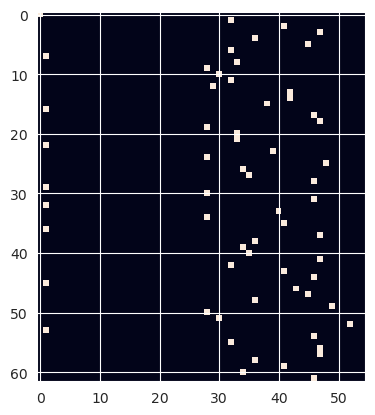

In [8]:
xenc = F.one_hot(xs, num_classes=55).float()
plt.imshow(xenc)

We interpret that the NN outputs `logcounts`

In [9]:
xenc.shape

torch.Size([62, 55])

In [10]:
g = torch.Generator().manual_seed(2468975301)
W = torch.randn((len(vocab), len(vocab)), generator=g)

Lines 2-3 is basically `softmax`

In [11]:
xenc = F.one_hot(xs, num_classes=55).float() # input to the network: one-hot encoding
logits = (xenc @ W)
counts = logits.exp() # equivalent to bigram_counts
probs = counts/counts.sum(axis=1, keepdims=True)
probs

tensor([[0.0280, 0.0363, 0.0198,  ..., 0.0239, 0.1015, 0.0023],
        [0.0239, 0.0163, 0.0117,  ..., 0.0078, 0.0061, 0.0351],
        [0.0093, 0.0091, 0.0045,  ..., 0.0121, 0.0093, 0.0218],
        ...,
        [0.0093, 0.0091, 0.0045,  ..., 0.0121, 0.0093, 0.0218],
        [0.0226, 0.0037, 0.0909,  ..., 0.0012, 0.0114, 0.0113],
        [0.0120, 0.0086, 0.0009,  ..., 0.0445, 0.0178, 0.0040]])

In [12]:
nlls = torch.zeros(len(xenc))
for i in range(len(xenc)):
  x = xs[i].item() # input character idx
  y = ys[i].item() # label character idx  
  print(f"bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})")
  print(f"input to the NN: {x}")
  print(f"output probabilities from NN: {probs[i]}")
  print(f"label (actual next character): {y}")
  p = probs[i, y]
  print(f"probability assigned by the NN to the correct character: {p.item()}")
  logp = torch.log(p)
  print(f"log liklihood: {logp.item()}")
  nll = -logp
  print(f"negative log liklihood: {nll.item()}")
  nlls[i] = nll
  print("-"*50)

print("="*50)  
print(f"average nll: {nlls.mean().item()}")

bigram example 1: #e (indexes 0, 32)
input to the NN: 0
output probabilities from NN: tensor([0.0280, 0.0363, 0.0198, 0.0039, 0.0421, 0.0045, 0.0242, 0.0101, 0.0154,
        0.0766, 0.0099, 0.0074, 0.0576, 0.0195, 0.0129, 0.0037, 0.0021, 0.0082,
        0.0112, 0.0048, 0.0124, 0.0176, 0.0203, 0.0062, 0.0031, 0.0250, 0.0234,
        0.0262, 0.0056, 0.0046, 0.0516, 0.0641, 0.0060, 0.0095, 0.0055, 0.0174,
        0.0142, 0.0230, 0.0049, 0.0146, 0.0062, 0.0224, 0.0084, 0.0109, 0.0062,
        0.0087, 0.0137, 0.0007, 0.0061, 0.0263, 0.0070, 0.0024, 0.0239, 0.1015,
        0.0023])
label (actual next character): 32
probability assigned by the NN to the correct character: 0.005997989326715469
log liklihood: -5.116331100463867
negative log liklihood: 5.116331100463867
--------------------------------------------------
bigram example 2: en (indexes 32, 41)
input to the NN: 32
output probabilities from NN: tensor([0.0239, 0.0163, 0.0117, 0.0047, 0.0056, 0.0126, 0.0344, 0.0031, 0.0009,
        0.

In [13]:
xs

tensor([ 0, 32, 41, 47, 36, 45, 32,  1, 33, 28, 30, 32, 29, 42, 42, 38,  1, 46,
        47, 28, 33, 33,  1, 39, 28, 48, 34, 35, 46,  1, 28, 46,  1, 40, 28, 41,
         1, 47, 36, 34, 35, 47, 32, 41, 46,  1, 43, 45, 36, 49, 28, 30, 52,  1,
        46, 32, 47, 47, 36, 41, 34, 46])

In [14]:
ys

tensor([32, 41, 47, 36, 45, 32,  1, 33, 28, 30, 32, 29, 42, 42, 38,  1, 46, 47,
        28, 33, 33,  1, 39, 28, 48, 34, 35, 46,  1, 28, 46,  1, 40, 28, 41,  1,
        47, 36, 34, 35, 47, 32, 41, 46,  1, 43, 45, 36, 49, 28, 30, 52,  1, 46,
        32, 47, 47, 36, 41, 34, 46,  0])

In [15]:
g = torch.Generator().manual_seed(2468975301)
W = torch.randn((len(vocab), len(vocab)), generator=g, requires_grad=True)

Pluck out the probs corresponding to the indices in `ys`

This is the forward pass

In [51]:
xenc = F.one_hot(xs, num_classes=len(vocab)).float() # input to the network: one-hot encoding
logits = (xenc @ W)
counts = logits.exp() # equivalent to bigram_counts
probs = counts/counts.sum(axis=1, keepdims=True)
loss = -probs[torch.arange(len(ys)), ys].log().mean()
print(f"{loss.item():0.4f}")

4.3352


Backward pass

In [52]:
W.grad = None # set grad to zero
loss.backward()
W.data += -0.1 * W.grad

In [22]:
torch.set_printoptions(threshold=1000)